# # Remaining Useful Life Prediction with Informer on PHM08 Dataset

In [82]:
# %% [markdown]
# ## 1. Setup and Imports
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import mlflow

In [90]:
# %% [markdown]
# Setup ML flow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("predictive-rul-deep-learning")

2025/09/17 12:38:43 INFO mlflow.tracking.fluent: Experiment with name 'predictive-rul-deep-learning' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/sagemaker-user/rul-estimation/notebooks/mlruns/714399029621557653', creation_time=1758112723694, experiment_id='714399029621557653', last_update_time=1758112723694, lifecycle_stage='active', name='predictive-rul-deep-learning', tags={}>

In [91]:
from typing import Dict, Any
import mlflow

def start_mlflow_run(params: Dict[str, Any]):
    """
    params: dict of hyperparameters and run context to record once per run.
    """
    run = mlflow.start_run()
    mlflow.set_tag("project", "RUL-estimation")
    mlflow.set_tag("author", "Pol John Cruz")
    mlflow.set_tag("dataset", "PHM08 Dataset")
    mlflow.log_params(params)
    return run

def log_epoch_metrics(epoch: int, train_loss: float, val_loss: float = None, extra: Dict[str, float] = None):
    mlflow.log_metric("train_loss", train_loss, step=epoch)
    if val_loss is not None:
        mlflow.log_metric("val_loss", val_loss, step=epoch)
    if extra:
        for k, v in extra.items():
            mlflow.log_metric(k, v, step=epoch)


In [92]:
# %% [markdown]
# ## 3. Load and Preprocess Data
def load_phm08(path, filename):
    cols = list(range(26))  # 26 columns
    df = pd.read_csv(os.path.join(path, filename), sep="\s+", header=None, names=cols)
    return df

train_df = load_phm08("../data/Challenge_Data/", "train.txt")
test_df = load_phm08("../data/Challenge_Data/", "test.txt")

# Extract RUL for training set
rul_per_unit = train_df.groupby(0)[1].max().reset_index()
rul_per_unit.columns = ["unit", "max_cycle"]
train_df = train_df.rename(columns={0: "unit", 1: "cycle"})
train_df = train_df.merge(rul_per_unit, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]
# train_df["RUL"] = np.log(train_df["max_cycle"] - train_df["cycle"] + 0.00001 + 1)
# rul_max = train_df.groupby("unit")["RUL"].max().reset_index()
# rul_max.columns = ["unit", "max_RUL"]
# train_df = train_df.merge(rul_max, on="unit", how="left")
# train_df["RUL"] /= train_df["max_RUL"]
# train_df = train_df.drop("max_RUL", axis=1)

# Extract RUL for training set
rul_per_unit_test = test_df.groupby(0)[1].max().reset_index()
rul_per_unit_test.columns = ["unit", "max_cycle"]
test_df = test_df.rename(columns={0: "unit", 1: "cycle"})
test_df = test_df.merge(rul_per_unit_test, on="unit", how="left")
test_df["RUL"] = test_df["max_cycle"] - test_df["cycle"]
# test_df["RUL"] = np.log(test_df["max_cycle"] - test_df["cycle"] + 0.00001 + 1)
# rul_max_test = test_df.groupby("unit")["RUL"].max().reset_index()
# rul_max_test.columns = ["unit", "max_RUL"]
# test_df = test_df.merge(rul_max_test, on="unit", how="left")
# test_df["RUL"] /= test_df["max_RUL"]
# test_df = test_df.drop("max_RUL", axis=1)


In [93]:
# cols_drop = [4,5,9,10,14,20,22,23]
# train_df = train_df.drop(cols_drop,axis=1)
# test_df = test_df.drop(cols_drop,axis=1)

In [94]:
train_df

,unit,cycle,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,max_cycle,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


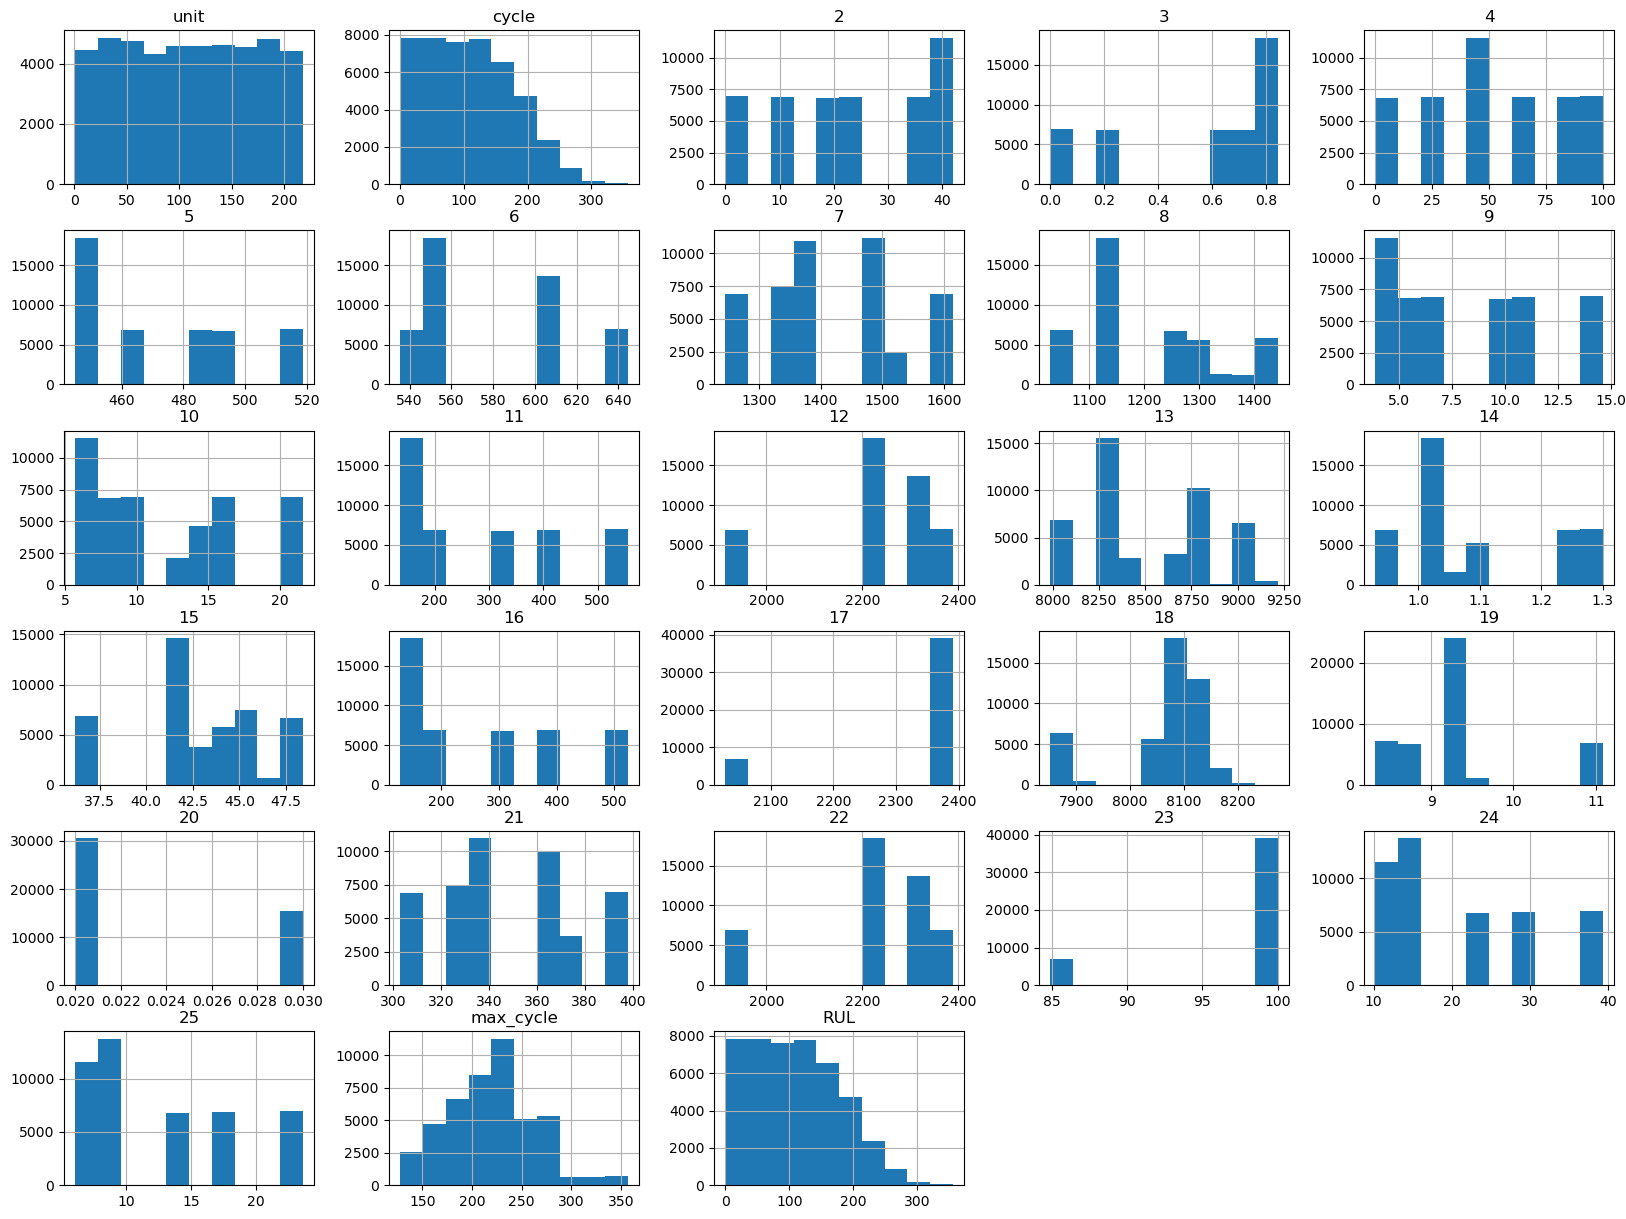

In [95]:
train_df.hist(bins=10, figsize=(20,15))
plt.show()

In [96]:
# %% [markdown]
# ## 4. Sliding Window Dataset
class PHM08RULDataset(Dataset):
    def __init__(self, df, seq_len=30, unit_ids=None):
        """
        df       : preprocessed dataframe with ['unit','cycle','RUL', features...]
        seq_len  : sequence length for time series
        unit_ids : list of engine IDs to include (if None → use all units)
        """
        if unit_ids is not None:
            self.df = df[df["unit"].isin(unit_ids)].reset_index(drop=True)
        else:
            self.df = df.copy().reset_index(drop=True)

        self.seq_len = seq_len

        # Features = all numeric columns except meta/labels
        self.features = self.df.columns.difference(
            ["unit", "cycle", "max_cycle", "RUL"]
        ).tolist()

        # Build all (X,y) sequences
        self.samples = []
        grouped = self.df.groupby("unit")
        for _, group in grouped:
            group = group.sort_values("cycle")
            values = group[self.features].values
            rul_values = group["RUL"].values

            for i in range(len(group) - seq_len + 1):
                x_seq = values[i:i+seq_len]
                y_val = rul_values[i+seq_len-1]
                self.samples.append((x_seq, y_val))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_len = 100
units = train_df["unit"].unique()   # all engine IDs

# First split into train+val vs test
training_units, test_units = train_test_split(units, test_size=0.1, random_state=42)
train_units, val_units = train_test_split(training_units, test_size=0.1, random_state=42)

# Apply Feature scaling to transform the scaling of different features into similar scales.
feature_cols = train_df.columns.difference(["unit", "cycle", "max_cycle", "RUL"])
training_df = train_df[train_df["unit"].isin(train_units)].copy()
val_df   = train_df[train_df["unit"].isin(val_units)].copy()
test_df   = train_df[train_df["unit"].isin(test_units)].copy()

scaler = StandardScaler()
training_df[feature_cols] = scaler.fit_transform(training_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

from torch.utils.data import Subset

train_dataset = PHM08RULDataset(training_df, seq_len=seq_len, unit_ids=train_units)
val_dataset   = PHM08RULDataset(val_df, seq_len=seq_len, unit_ids=val_units)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total engines: {len(units)}")
print(f"Total train engines: {len(train_units)}")
print(f"Total validation engines: {len(val_units)}")
print(f"Total test engines: {test_units}")

Total engines: 218
Total train engines: 176
Total validation engines: 20
Total test engines: [101 216 140 179  16 155 171  74 208 141 190  31 212  10  68 178 174  19
 156  67 193 144]


In [97]:
# ----------------------
# RNN Encoder-Decoder
# ----------------------
class RNNRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=56, num_layers=2, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim1, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out, _ = self.rnn(x)           # [B, L, H]
        out = out[:, -1, :]            # take last timestep
        out = self.bn(out)             # batch norm
        out = self.dropout1(out)       # first dropout

        out, _ = self.rnn2(out.unsqueeze(1))  # add 2nd RNN
        out = out[:, -1, :]

        out = self.dropout2(out)
        out = self.fc(out)
        return self.relu(out).squeeze(-1)

# ----------------------
# LSTM Encoder-Decoder
# ----------------------
class LSTMRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=56, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.dropout1(out)

        out, _ = self.lstm2(out.unsqueeze(1))
        out = out[:, -1, :]

        out = self.dropout2(out)
        out = self.fc(out)
        return self.relu(out).squeeze(-1)
# ----------------------
# Seq2Seq Encoder-Decoder
# ----------------------
class Seq2SeqRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=56, num_layers=2, dropout=0.3):
        super().__init__()
        # Encoder
        self.encoder1 = nn.LSTM(input_dim, hidden_dim1, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)

        # Second Encoder-like block
        self.encoder2 = nn.LSTM(hidden_dim1, hidden_dim2, num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim2, 1)


    def forward(self, x):
        enc_out, _ = self.encoder1(x)
        out = enc_out[:, -1, :]        # last timestep
        out = self.bn(out)
        out = self.dropout1(out)

        out, _ = self.encoder2(out.unsqueeze(1))
        out = out[:, -1, :]

        out = self.dropout2(out)
        out = self.fc(out)
        return self.relu(out).squeeze(-1)

In [98]:
# %% [markdown]
# ----------------------
# Informer
# ----------------------
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, L, D = x.shape
        H = self.n_heads

        Q = self.q_linear(x).view(B, L, H, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, L, H, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, L, H, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.fc_out(out)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=256, dropout=0.1):
        super().__init__()
        self.attn = ProbSparseSelfAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out = self.attn(x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


class InformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, n_heads, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class InformerRUL(nn.Module):
    def __init__(self, num_features, d_model=128, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.encoder = InformerEncoder(num_layers, d_model, n_heads, dropout)
        self.regressor = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)         # [B, L, d_model]
        x = self.encoder(x)            # [B, L, d_model]
        x = x.transpose(1, 2)          # [B, d_model, L]
        out = self.regressor(x)        # [B, 1]
        return out.squeeze(-1)

In [99]:
# %% [markdown]
# ## 6. Training Function
import time

def train_model(model, train_loader, val_loader, opt="adam", device="cpu", epochs=20, lr=1e-3, mlflow=0):   
    model.to(device)
    criterion = nn.MSELoss()
    if opt == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "rms":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs+1):
        train_preds = []
        train_true_rul = []
        val_preds = []
        val_true_rul = []

        start = time.time()
        model.train()
        total_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader, 1):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            train_preds.extend(pred.cpu().detach().numpy().ravel())
            train_true_rul.extend(y.cpu().detach().numpy().ravel())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # # Print every 50 batches
            # if batch_idx % 50 == 0 or batch_idx == len(train_loader):
            #     print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_preds.extend(pred.cpu().numpy().ravel())
                val_true_rul.extend(y.cpu().numpy().ravel())
                val_loss += criterion(pred, y).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        end = time.time()
        total_time = end-start
        print(f"Epoch {epoch} Completed — Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f} | Time Elapsed: {total_time:.2f} seconds")
        if mlflow==1:
            log_epoch_metrics(epoch, avg_train_loss, avg_val_loss)
    print("-"*60)

    return train_preds, train_true_rul, val_preds, val_true_rul, train_losses, val_losses

In [100]:
# Model selection
# Select models from RNN, LSTM, Informer ["RNN", "LSTM", "Seq2Seq", "Informer"]
num_features=len(train_dataset.features)

models = {
    "RNN": RNNRUL(num_features),
    "LSTM": LSTMRUL(num_features),
    "Seq2Seq": Seq2SeqRUL(num_features),
    "Informer": InformerRUL(num_features=len(train_dataset.features), d_model=128, n_heads=4, num_layers=2, dropout=0.1)   
}

In [101]:
from itertools import product

def grid_search(model_class, param_grid, train_dataset, val_dataset, train_units, val_units, device="cuda"):
    results = []
    best_model = None
    best_loss = float("inf")

    # Build train/val loaders
    for params in product(*param_grid.values()):
        hp = dict(zip(param_grid.keys(), params))

        # Sequencing
        seq_len = hp.get("seq_len",10)

        # Apply Feature scaling to transform the scaling of different features into similar scales.
        feature_cols = train_df.columns.difference(["unit", "cycle", "max_cycle", "RUL"])
        training_df = train_df[train_df["unit"].isin(train_units)].copy()
        val_df   = train_df[train_df["unit"].isin(val_units)].copy()
        
        scaler = StandardScaler()
        training_df[feature_cols] = scaler.fit_transform(training_df[feature_cols])
        val_df[feature_cols]   = scaler.transform(val_df[feature_cols])

        train_dataset = PHM08RULDataset(training_df, seq_len=seq_len, unit_ids=train_units)
        val_dataset   = PHM08RULDataset(val_df, seq_len=seq_len, unit_ids=val_units)

        # Dataloaders
        train_loader = DataLoader(train_dataset, batch_size=hp.get("batch_size",64), shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=hp.get("batch_size",64))

        # Model
        if model_class.__name__ == "InformerRUL":
            model = model_class(
                num_features=len(train_dataset.features),
                d_model=hp.get("d_model", 128),
                n_heads=hp.get("n_heads", 4),
                num_layers=hp.get("num_layers", 2)
            )
            run_params = {
            "model": model_class.__name__,
            "dataset": "PHM08 Dataset",  
            # ---- hyperparams  ---- #
            "d_model": hp.get("d_model", 64),
            "n_heads": hp.get("n_heads", 1),
            "num_layers": hp.get("num_layers", 1),
            "batch_size": hp.get("batch_size",64),
            "dropout": hp.get("dropout", 0.1),
            "seq_len": hp.get("seq_len",10),
            "lr": hp.get("lr", 1e-3),
            "epochs": hp.get("epochs", 20),
            "opt": hp.get("opt", "adam"),
            "device": device
            # -------------------- #
            }

        else:
            model = model_class(
                input_dim=len(train_dataset.features),
                hidden_dim1=hp.get("hidden_dim1", 128),
                hidden_dim2=hp.get("hidden_dim2", 128),
                num_layers=hp.get("num_layers", 1),
                dropout=hp.get("dropout", 0.1)
            )
            run_params = {
            "model": model_class.__name__,
            "dataset": "PHM08 Dataset",  
            # ---- hyperparams  ---- #
            "input_dim": num_features,
            "hidden_dim1": hp.get("hidden_dim1", 128),
            "hidden_dim2": hp.get("hidden_dim2", 128),
            "num_layers": hp.get("num_layers", 1),
            "dropout": hp.get("dropout", 0.1),
            "batch_size": hp.get("batch_size",64),
            "seq_len": hp.get("seq_len",10),
            "lr": hp.get("lr", 1e-3),
            "epochs": hp.get("epochs", 20),
            "opt": hp.get("opt", "adam"),
            "device": device
            # -------------------- #
            }


        #Initiate MLFlow run
        run = start_mlflow_run(run_params)
        start_time = time.time()

        
        print(f"\n🔎 Training with model {model.__class__.__name__} params: {hp}")
        train_preds, train_true_rul, val_preds, val_true_rul, train_loss, val_loss = train_model(
            model, train_loader, val_loader,
            epochs=hp.get("epochs", 20),
            lr=hp.get("lr", 1e-3),
            opt=hp.get("opt", "adam"),
            device=device,
            mlflow=1
        )
        train_secs = time.time() - start_time
        mlflow.log_metric("train_time_sec", train_secs)
        mlflow.end_run()
        results.append((hp, train_loss))

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            best_model = model
            best_params = hp

    
    print("\n✅ Grid Search Complete")
    print(f"Best Params: {results[min(range(len(results)), key=lambda i: results[i][1])][0]}")
    print(f"Best Val Loss: {best_loss:.4f}")

    return best_model, best_params, best_loss, results


In [107]:
# Perform grid search with MLFlow

model_results = {}
model_names = ["Informer", "RNN", "LSTM", "Seq2Seq"]   # <-- change to "RNN", "LSTM", "Seq2Seq", "Informer"
device="cuda" if torch.cuda.is_available() else "cpu"

# Stops MLFlow instance if it exists
mlflow.end_run()

for model_name in model_names:
    model = models[model_name].to(device)
    if model_name == "Informer":
        param_grid = {
        "opt": ["rms", "adam"], 
        "seq_len": [100],
        "batch_size": [32, 64],
        "lr": [1e-3, 1e-2],
        "d_model": [64],
        "n_heads": [2],
        "num_layers": [1],
        "epochs": [10],
        "dropout": [0.2]
        }
    else:
        param_grid = {
        "opt": ["rms", "adam"], 
        "hidden_dim1": [128],
        "hidden_dim2": [64],
        "num_layers": [1, 2],
        "dropout": [0.2],
        "seq_len": [100],
        "batch_size": [32, 64],
        "lr": [1e-3, 1e-2],
        "epochs": [10]  
        }
    best_model, best_params, best_loss, results = grid_search(
        model.__class__, param_grid,
        train_dataset, val_dataset, train_units, val_units, 
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    model_results[model.__class__.__name__] =  {
                                                    "Best Model": best_model,
                                                    "Best Params": best_params,
                                                    "Best Loss": best_loss,
                                                    "results": results
                                                }



🔎 Training with model InformerRUL params: {'opt': 'rms', 'seq_len': 100, 'batch_size': 32, 'lr': 0.001, 'd_model': 64, 'n_heads': 2, 'num_layers': 1, 'epochs': 10, 'dropout': 0.2}
Epoch 1 Completed — Avg Train Loss: 2540.3807 | Avg Val Loss: 1760.2658 | Time Elapsed: 2.26 seconds
Epoch 2 Completed — Avg Train Loss: 1163.2790 | Avg Val Loss: 1449.2430 | Time Elapsed: 2.24 seconds
Epoch 3 Completed — Avg Train Loss: 970.0809 | Avg Val Loss: 1179.2244 | Time Elapsed: 2.25 seconds
Epoch 4 Completed — Avg Train Loss: 835.0808 | Avg Val Loss: 1513.8539 | Time Elapsed: 2.24 seconds
Epoch 5 Completed — Avg Train Loss: 842.0893 | Avg Val Loss: 1180.2885 | Time Elapsed: 2.24 seconds
Epoch 6 Completed — Avg Train Loss: 716.4813 | Avg Val Loss: 1049.3468 | Time Elapsed: 2.24 seconds
Epoch 7 Completed — Avg Train Loss: 643.5516 | Avg Val Loss: 989.3197 | Time Elapsed: 2.23 seconds
Epoch 8 Completed — Avg Train Loss: 584.0395 | Avg Val Loss: 867.0367 | Time Elapsed: 2.24 seconds
Epoch 9 Completed —

## Check performance in MLflow UI.
Run in terminal `mlflow ui --port 5000`

Open `http://127.0.0.1:5000/` in browser.

In [103]:
# summary = []

# for model_name, info in model_results.items():
#     # pick best (lowest val_loss) from results
#     best_params, best_loss = min(info["results"], key=lambda x: x[1])
#     summary.append({
#         "Model": model_name,
#         "Best Params": best_params,
#         "Best Val Loss": best_loss
#     })

# df_summary = pd.DataFrame(summary)
# df_summary

In [104]:
# model_results

In [105]:
# %% [markdown]
# ## 7. Run Training
model_name = "Seq2Seq"   # <-- change to "Informer", "RNN", "LSTM", or "Seq2Seq"
seq_len = 100
batch_size = 32
lr = 1e-2
epochs = 10
opt = "adam" # <-- change to "adam", "rms"
device="cuda" if torch.cuda.is_available() else "cpu"

num_features=len(train_dataset.features)

print(f"Using device: {device}")

model = models[model_name]

Using device: cuda


In [106]:
# Model
if model.__class__.__name__ == "InformerRUL":
    params = {
        "num_features": num_features,
        "d_model": 128,
        "n_heads": 4,
        "num_layers": 1,
        "dropout": 0.2
        }
    model = model.__class__(**params
    )
    run_params = {
    "model":  model.__class__.__name__,
    "dataset": "PHM08 Dataset",  
    # ---- hyperparams  ---- #
    **params,
    "batch_size": batch_size,
    "seq_len": seq_len,
    "lr": lr,
    "epochs": epochs,
    "opt": opt,
    "device": device
    # -------------------- #
    }

else:
    params = {
        "input_dim": num_features,
        "hidden_dim1": 128,
        "hidden_dim2": 64,
        "num_layers": 1,
        "dropout": 0.2,
        }
    model = model.__class__(**params)
    run_params = {
    "model":  model.__class__.__name__,
    "dataset": "PHM08 Dataset",  
    # ---- hyperparams  ---- #
    **params,
    "batch_size": batch_size,
    "seq_len": seq_len,
    "lr": lr,
    "epochs": epochs,
    "opt": opt,
    "device": device
    # -------------------- #
    }

In [54]:
# Sequencing
units = train_df["unit"].unique()   # all engine IDs
training_units, test_units = train_test_split(units, test_size=0.1, random_state=42)
train_units, val_units = train_test_split(training_units, test_size=0.1, random_state=42)

# Apply Feature scaling to transform the scaling of different features into similar scales.
feature_cols = train_df.columns.difference(["unit", "cycle", "max_cycle", "RUL"])
training_df = train_df[train_df["unit"].isin(train_units)].copy()
val_df   = train_df[train_df["unit"].isin(val_units)].copy()
test_df   = train_df[train_df["unit"].isin(test_units)].copy()

scaler = StandardScaler()
training_df[feature_cols] = scaler.fit_transform(training_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

train_dataset = PHM08RULDataset(training_df, seq_len=seq_len, unit_ids=train_units)
val_dataset   = PHM08RULDataset(val_df, seq_len=seq_len, unit_ids=val_units)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

print(f"Total engines: {len(units)}")
print(f"Total train engines: {len(train_units)}")
print(f"Total validation engines: {len(val_units)}")
print(f"Total test engines: {len(test_units)}")

Total engines: 218
Total train engines: 176
Total validation engines: 20
Total test engines: 22


In [55]:
print("Starting training...")
 #Initiate MLFlow run
mlflow_set = 0

if mlflow_set == 1:
    print("Initiate MLFlow logs...")
    run = start_mlflow_run(run_params)
    start_time = time.time()
train_preds, train_true_rul, val_preds, val_true_rul, train_loss, val_loss = train_model(
            model, train_loader, val_loader,
            epochs=epochs,
            lr=lr,
            opt=opt,
            device=device,
            mlflow=mlflow_set
        )
if mlflow_set == 1:
    train_secs = time.time() - start_time
    mlflow.log_metric("train_time_sec", train_secs)
    mlflow.end_run()
print("Training completed.")

import joblib
# Save model
joblib.dump(model, "model/model.pkl")


Starting training...
Epoch 1 Completed — Avg Train Loss: 2159.6407 | Avg Val Loss: 1605.0967 | Time Elapsed: 1.96 seconds
Epoch 2 Completed — Avg Train Loss: 921.1072 | Avg Val Loss: 1307.6120 | Time Elapsed: 1.93 seconds
Epoch 3 Completed — Avg Train Loss: 792.0678 | Avg Val Loss: 951.1172 | Time Elapsed: 1.94 seconds
Epoch 4 Completed — Avg Train Loss: 753.0346 | Avg Val Loss: 819.6343 | Time Elapsed: 1.95 seconds
Epoch 5 Completed — Avg Train Loss: 772.4391 | Avg Val Loss: 869.4057 | Time Elapsed: 1.94 seconds
Epoch 6 Completed — Avg Train Loss: 754.9487 | Avg Val Loss: 1480.3143 | Time Elapsed: 1.95 seconds
Epoch 7 Completed — Avg Train Loss: 737.3107 | Avg Val Loss: 1206.5277 | Time Elapsed: 1.94 seconds
Epoch 8 Completed — Avg Train Loss: 746.8673 | Avg Val Loss: 790.7063 | Time Elapsed: 1.94 seconds
Epoch 9 Completed — Avg Train Loss: 713.9959 | Avg Val Loss: 1422.3668 | Time Elapsed: 1.94 seconds
Epoch 10 Completed — Avg Train Loss: 670.6966 | Avg Val Loss: 932.0440 | Time Elap

['model/model.pkl']

In [58]:
model

Seq2SeqRUL(
  (encoder1): LSTM(24, 128, batch_first=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (encoder2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [59]:
summary(model, input_size=(batch_size, seq_len, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2SeqRUL                               [32]                      --
├─LSTM: 1-1                              [32, 100, 128]            78,848
├─BatchNorm1d: 1-2                       [32, 128]                 256
├─Dropout: 1-3                           [32, 128]                 --
├─LSTM: 1-4                              [32, 1, 64]               49,664
├─Dropout: 1-5                           [32, 64]                  --
├─Linear: 1-6                            [32, 1]                   65
├─ReLU: 1-7                              [32, 1]                   --
Total params: 128,833
Trainable params: 128,833
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 253.91
Input size (MB): 0.31
Forward/backward pass size (MB): 3.33
Params size (MB): 0.52
Estimated Total Size (MB): 4.15

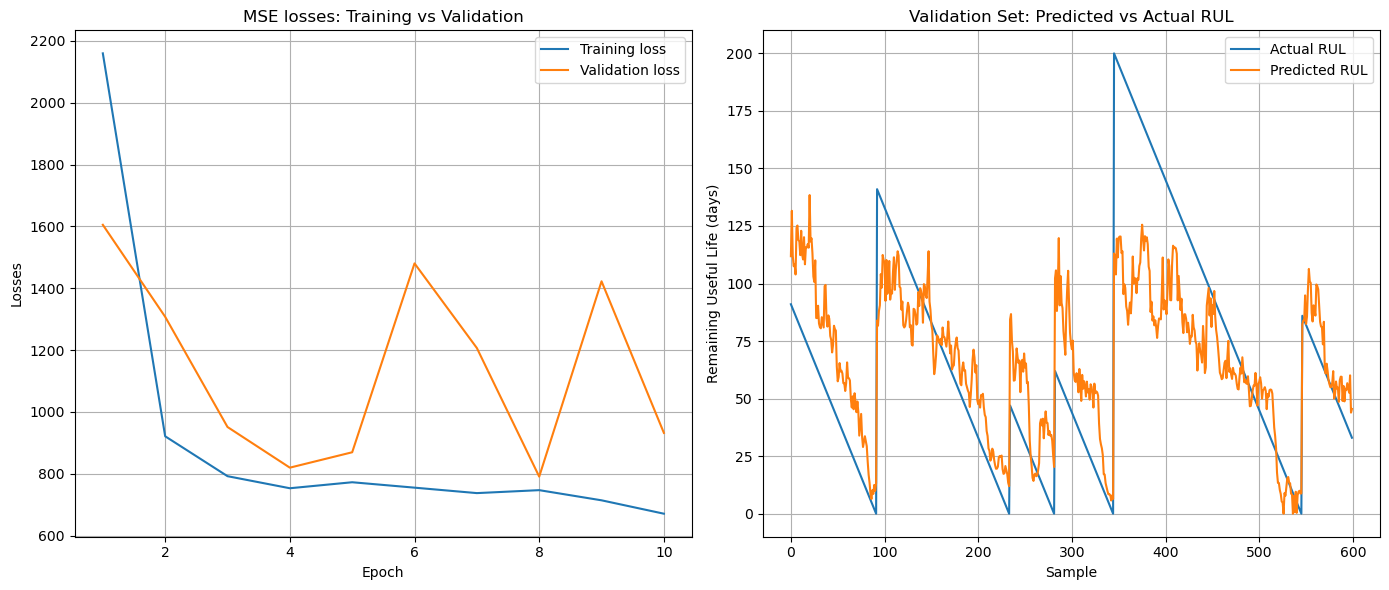

In [60]:
plt.figure(figsize=(14,6))
train_preds, train_true_rul, val_preds, val_true_rul, train_loss, val_loss
# Training
plt.subplot(1,2,1)
plt.plot(np.arange(1, epochs+1), train_loss, label="Training loss")
plt.plot(np.arange(1, epochs+1), val_loss, label="Validation loss")
plt.title("MSE losses: Training vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.grid(visible=True)
# plt.xticks(range(1,epochs+1))
plt.legend()

# Validation
plt.subplot(1,2,2)
plt.plot(val_true_rul[:600], label="Actual RUL")
plt.plot(val_preds[:600], label="Predicted RUL")
plt.title("Validation Set: Predicted vs Actual RUL")
plt.xlabel("Sample")
plt.ylabel("Remaining Useful Life (days)")
plt.grid(visible=True)
plt.legend()

plt.tight_layout()
plt.show()

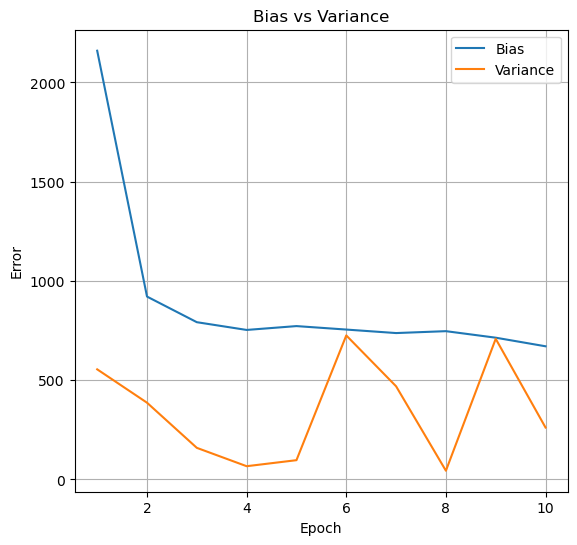

In [61]:
# Bias and Variance
plt.figure(figsize=(14,6))
train_preds, train_true_rul, val_preds, val_true_rul, train_loss, val_loss
variance = [abs(val_loss[i] - train_loss[i]) for i in range(len(val_loss))]

# Training
plt.subplot(1,2,1)
plt.plot(np.arange(1, epochs+1), train_loss, label="Bias")
plt.plot(np.arange(1, epochs+1), variance, label="Variance")
plt.title("Bias vs Variance")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.grid(visible=True)
# plt.xticks(range(1,epochs+1))
plt.legend()

In [62]:
model.__class__.__name__

'Seq2SeqRUL'

In [65]:
# Load parameters
MODEL_PATH = "model/model.pkl"
model = joblib.load(MODEL_PATH)

Test Set Evaluation:
MSE: 514.6559


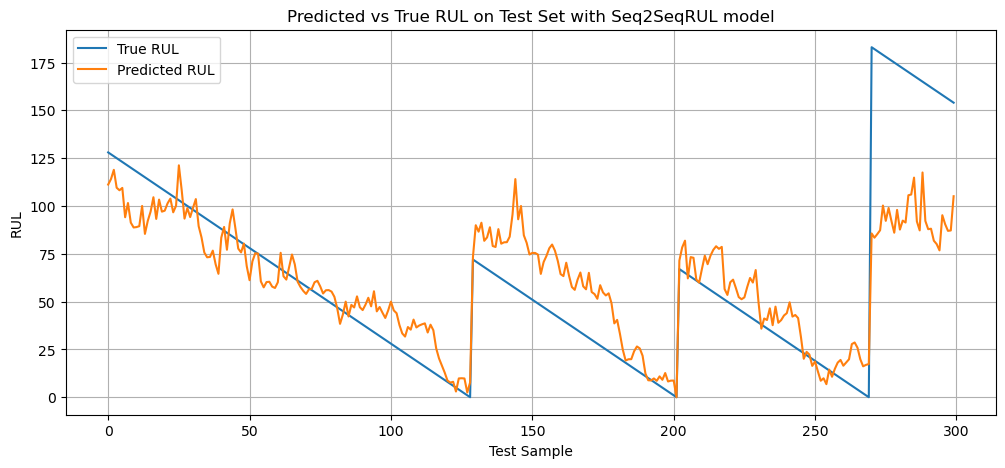

In [66]:
# %% [markdown]
# ## 8. Evaluation on Test Set (if RUL available) or inference
# Preprocess test_df for inference

# test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

test_dataset  = PHM08RULDataset(test_df, seq_len=seq_len, unit_ids=test_units)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
preds = []
true_rul = []
test_loss = 0

model.to(device)
criterion = nn.MSELoss()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        output = model(x_test)
        preds.extend(output.cpu().numpy().ravel())
        true_rul.extend(y_test.cpu().numpy().ravel())
        test_loss += criterion(output, y_test).item()
avg_test_loss = test_loss / len(test_loader)

print("="*60)
print(f"Test Set Evaluation:")
print(f"MSE: {avg_test_loss:.4f}")
print("="*60)

# Optional: visualize predicted vs true RUL
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(true_rul[:300], label="True RUL")
plt.plot(preds[:300], label="Predicted RUL")
plt.xlabel("Test Sample")
plt.ylabel("RUL")
plt.grid(visible=True)
plt.title("Predicted vs True RUL on Test Set with " + str(model.__class__.__name__) + " model")
plt.legend()
plt.show()


In [70]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib   # or pickle
import numpy as np
import pandas as pd
from evidently import Report
from evidently.metrics import *        # or specific metrics
from evidently.presets import *        # e.g. DataDriftPreset

In [71]:
# Load data
MODEL_PATH = "model/model.pkl"
model = joblib.load(MODEL_PATH)

# FastAPI app
app = FastAPI(title="RUL Prediction Service (Pickle Model)", version="1.0")

# Request schema
class SensorData(BaseModel):
    values: list[float]   # e.g., [sensor1, sensor2, sensor3, ...]

# ---------------------------
# Inference Endpoint
# ---------------------------
@app.post("/predict")
def predict(data: SensorData):
    X = np.array(data.values).reshape(1, -1)
    prediction = model.predict(X)[0]
    return {"predicted_RUL": float(prediction)}

# ---------------------------
# Healthcheck Endpoint
# ---------------------------
@app.get("/healthcheck")
def healthcheck():
    return {"status": "ok", "model_loaded": model is not None}

# ---------------------------
# Drift Detection (periodic use)
# ---------------------------
@app.post("/check-drift")
def check_drift(new_data: list[SensorData]):
    # Convert incoming batch to DataFrame
    new_df = pd.DataFrame([d.values for d in new_data])
    
    # Build Evidently drift report
    report = Report([
        DataDriftPreset(),
        # you can add others
    ])
    
    my_eval = report.run(reference_data=ref_df, current_data=new_df)
    drift_detected_flag = my_eval.as_dict()["metrics"][0]["result"]["dataset_drift"]
    
    return {
        "drift": bool(drift_detected_flag),
        "details": my_eval.as_dict()["metrics"][0]["result"]
    }

# ---------------------------
# Retrain Trigger (placeholder)
# ---------------------------
@app.post("/retrain")
def retrain():
    return {"status": "triggered", "message": "Retraining pipeline started."}

    

In [ ]:
uvicorn service:app --host 0.0.0.0 --port 8000